In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import scipy.io as sio
import glob
import cv2
from sklearn import svm
from scipy import signal
from skimage.filters import threshold_otsu
from matplotlib.patches import Circle
from sklearn.cluster import KMeans
from scipy import stats

In [ ]:
data=sio.loadmat('/content/drive/MyDrive/AumentoThermo/Datasets/ima_distor.mat')

In [ ]:
images=data['images']
images=((images-np.min(images))/(np.max(images)-np.min(images))).astype('float32')
labels=data['labels'][0]
np.shape(images), np.shape(labels)

((6695, 128, 128, 3), (6695,))

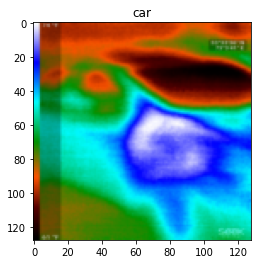

In [ ]:
Class=['man', 'cat', 'car']
sx=np.shape(labels)[0]
ind=np.random.choice(sx)
plt.title(Class[labels[ind]])
plt.imshow(images[ind])

In [ ]:
def one_hot(vec):
  items=np.sort(pd.unique(vec))
  n_class=np.shape(items)[0]
  resul=np.zeros((vec.size, n_class))
  for n,i in enumerate(items):
    rows=np.where(vec==i)[0]
    resul[rows,n]=1
  return resul.astype('float32')

In [ ]:
def get_index(data, run, k_fold=5):
  tm=np.shape(data)[0]
  anch=int(tm/k_fold)
  fold=run%k_fold
  np.random.seed(2000)
  ind=np.random.choice(tm,tm, replace=False)
  i_test=ind[fold*anch:(fold+1)*anch]
  i_train=np.delete(ind, np.arange(fold*anch,(fold+1)*anch))
  return i_train, i_test

In [ ]:
from tensorflow.keras import applications as ap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.compat.v1.keras.backend as K
import os
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import time
from IPython.display import clear_output

In [ ]:
def get_model(network, opt='adadelta', loss_name='categorical_crossentropy', input_shape=(128,128,3), classes=3, weights='imagenet'):
  try:
    del model
  except:
    print('done')
  model=Sequential()
  if network=='ResNet50V2':
    model.add(ap.ResNet50V2(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) # The input must have 3 channels
  if network=='EfficientNetB7':
    model.add(ap.EfficientNetB7(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='InceptionResNetV2':
    model.add(ap.InceptionResNetV2(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='InceptionV3':
    model.add(ap.InceptionV3(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='NASNetLarge':
    model.add(ap.NASNetLarge(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
  if network=='VGG19':
    model.add(ap.VGG19(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='Xception':
    model.add(ap.Xception(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
  if network=='DenseNet121':
    model.add(ap.DenseNet121(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
  
  model.add(Dense(classes, activation='softmax'))
  model.compile(optimizer=opt, loss=loss_name, metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives()])
  return model

In [ ]:
TP=tf.keras.metrics.TruePositives()
TN=tf.keras.metrics.TrueNegatives()
FP=tf.keras.metrics.FalsePositives()
FN=tf.keras.metrics.FalseNegatives()

In [ ]:
def without_aug(data, percentage=0):
  return data
methods={'None': without_aug}

In [ ]:
df = pd.DataFrame(columns=('run_n', 'k_fold', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time', 'transfer', 'augm', 'Class', 'TP', 'TN', 'FP', 'FN','result_mat'))
df.head()

,run_n,k_fold,network,optimizer,loss,epochs,total_parameters,time,transfer,augm,Class,TP,TN,FP,FN,result_mat


In [ ]:
def run_experiment(images, labels, number_class, data_augmentation, name='x', star_fold=0, star_run=0, end_run=6, batch_size=16):
  for augm_con in ['']:
    for net in ['ResNet50V2']:
      name_0='_'.join(['Thermo', name, str(transferlearning), augm_con, net, optimizer])
      if not os.path.exists(path2+name_0+'.csv'):
        df.to_csv(path2+name_0+'.csv')

      for n_fold in range(star_fold,5):
        train, test=get_index(labels, n_fold)
        x_train, y_train=images[train], one_hot(labels[train])
        x_test,  y_test=images[test], one_hot(labels[test])

        for i in range(star_run, end_run): #Numero corridas 
          for j in [loss]: #Funciones de perdida
            cntn=True
            name_m='_'.join([name_0,j,'run',str(i),'fold',str(n_fold)])  
            print(name_m)

            #Obtener imagenes nuevamente
            callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
            model=get_model(net, classes=number_class, weights=transferlearning)

            try:
              tic = time.time()
              results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[callback])
              toc=time.time()-tic
              model.save_weights(pathW+name_m+"w.h5")
            except:
              print('Training error')
              cntn=False

            if cntn:
              sio.savemat(pathW+name_m+'_r.mat', results.history)

              #Validation
              y_hat=np.array(model.predict(x_test))
              sio.savemat(pathW+name_m+'_los_8.mat',{'y_hat': y_hat, 'y_test': np.array(y_test)})
              #y_hat=y_hat>=0.5

              for class_i in range(number_class):
                TP.reset_state()
                TN.reset_state()
                FP.reset_state()
                FN.reset_state()        

                TP.update_state(y_test[:,class_i], y_hat[:,class_i])
                TN.update_state(y_test[:,class_i], y_hat[:,class_i])
                FP.update_state(y_test[:,class_i], y_hat[:,class_i])
                FN.update_state(y_test[:,class_i], y_hat[:,class_i])
                total_p=model.count_params()

                #data frame
                df2=pd.read_csv(path2+name_0+'.csv')
                df2=df2.append({'run_n': i,
                                'k_fold': n_fold,
                                'network': net,
                                'optimizer': optimizer,
                                'loss': 'categorical_crossentropy',
                                'epochs': epochs,
                                'total_parameters': total_p,
                                'time': toc,
                                'transfer': transferlearning,
                                'augm': augm_con,
                                'Class': class_i,
                                'TP': float(TP.result()),
                                'TN': float(TN.result()),
                                'FP': float(FP.result()),
                                'FN': float(FN.result()),
                                'result_mat': name_m+'_r.mat'} , ignore_index=True)
                df2=df2.drop(df2.columns[:np.where(df2.columns=='run_n')[0][0]], axis=1)
                df2.to_csv(path2+name_0+'.csv')
              del model, callback #x_train, y_train,
              clear_output(wait=True)
        star_run=0
      star_fold=0

In [ ]:
root='/content/drive/MyDrive/AumentoThermo'

Networks=['ResNet50V2']#, 'InceptionV3', 'DenseNet121', 'Xception', 'VGG19', 'InceptionResNetV2', 'EfficientNetB7']
path2=root+'/Results/Augmento/referencia/results_csv/'
pathW=root+'/Results/Augmento/referencia/Weights/'

augmentation=['None']
transferlearning='imagenet'
optimizer='adadelta'
epochs=100
loss='categorical_crossentropy'

#----------------------------------RUN------------------------------------------
run_experiment(images, labels, 3, augmentation, star_fold=0, star_run=0)

Thermo_x_imagenet__ResNet50V2_adadelta_categorical_crossentropy_run_5_fold_4
done
Epoch 1/100
335/335 [==============================] - 24s 53ms/step - loss: 1.0856 - acc: 0.4537 - recall_29: 0.2844 - false_positives_30: 1500.0000
Epoch 2/100
335/335 [==============================] - 18s 53ms/step - loss: 0.8112 - acc: 0.6432 - recall_29: 0.4783 - false_positives_30: 913.0000
Epoch 3/100
335/335 [==============================] - 18s 53ms/step - loss: 0.6497 - acc: 0.7517 - recall_29: 0.6171 - false_positives_30: 670.0000
Epoch 4/100
335/335 [==============================] - 18s 53ms/step - loss: 0.5233 - acc: 0.8202 - recall_29: 0.7240 - false_positives_30: 491.0000
Epoch 5/100
335/335 [==============================] - 18s 53ms/step - loss: 0.4368 - acc: 0.8613 - recall_29: 0.7864 - false_positives_30: 383.0000
Epoch 6/100
335/335 [==============================] - 18s 53ms/step - loss: 0.3811 - acc: 0.8816 - recall_29: 0.8237 - false_positives_30: 365.0000
Epoch 7/100
335/335 [==

### see results and to do transfer learning

In [ ]:
path='/content/drive/MyDrive/AumentoThermo/Results/Augmento/referencia'

In [ ]:
cs=glob.glob(path+'/results_csv/*.csv')

In [ ]:
cero=pd.read_csv(cs[0])
cero=cero.drop(cero.columns[:np.where(cero.columns=='run_n')[0][0]], axis=1)

In [ ]:
df = pd.DataFrame(columns=cero.columns)
df.head()

,run_n,k_fold,network,optimizer,loss,epochs,total_parameters,time,transfer,augm,Class,TP,TN,FP,FN,result_mat


In [ ]:
for name_c in cs:
  csv=pd.read_csv(name_c)
  df=df.append(csv, ignore_index=True)

In [ ]:
TP=np.array(df.loc[:,'TP'])
TN=np.array(df.loc[:,'TN'])
FP=np.array(df.loc[:,'FP'])
FN=np.array(df.loc[:,'FN'])

In [ ]:
df['Accuracy']= (TP+TN)/(TP+TN+FP+FN)
df['F1_score'] = (2*TP)/(2*TP+FP+FN)
df['Sensitivity'] = TP/(TP+FN)
df['Specificity'] = TN/(TN+FP)
df['Precision'] = TP/(TP+FP)
df['mean_metrics']=(((TP+TN)/(TP+TN+FP+FN))+((2*TP)/(2*TP+FP+FN))+(TP/(TP+FN))+(TN/(TN+FP))+(TP/(TP+FP)))/5

In [ ]:
lx='std'
dfx=df[["k_fold", "Accuracy", 'Sensitivity', 'Specificity', 'Precision', 'F1_score']].groupby("k_fold").describe()
maxim=dfx[[('Accuracy', 'mean'), ('Accuracy', 'std'),
           ('Sensitivity', 'mean'), ('Sensitivity', 'std'),
           ('Specificity', 'mean'), ('Specificity', 'std'),
           ('Precision', 'mean'), ('Precision', 'std'),
           ('F1_score', 'mean'), ('F1_score', 'std')]]*100
maxim

Accuracy           Sensitivity  ... Precision   F1_score          
             mean       std        mean  ...       std       mean       std
k_fold                                   ...                               
0       98.925400  0.232158   98.235474  ...  1.106811  98.297364  0.616552
1       98.651564  0.471967   97.840541  ...  1.303162  97.886001  0.920932
2       98.817526  0.270184   98.077714  ...  0.741846  98.179412  0.566091
3       98.937847  0.210543   98.272210  ...  0.724457  98.363536  0.442267
4       98.991785  0.200476   98.421167  ...  0.965646  98.462021  0.363292

[5 rows x 10 columns]

graphic
[0, 1, 2, 3, 4]


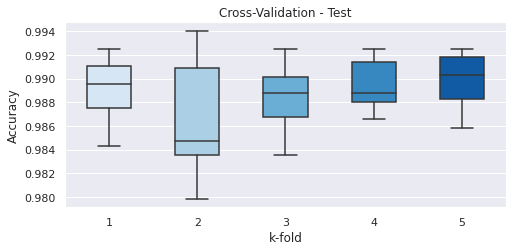

In [ ]:
order=list([0,1,2,3,4])
sns.set(rc={'figure.figsize':(7.9, 3.4)})
sns.set_theme(style="darkgrid")
sns.boxplot(x="k_fold", y="Accuracy", data=df, order=order, palette='Blues', width=0.5, saturation=1)
plt.xticks(ticks=np.arange(len(order)), labels=np.arange(len(order))+1, multialignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), labels=order)
plt.title('Cross-Validation - Test')
plt.xlabel('k-fold')
plt.ylabel('Accuracy')
print('graphic')
print(order)
plt.savefig('AccuracyGeneral.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#

In [ ]:
vgg=glob.glob(path+'/Weights/*_r.mat')

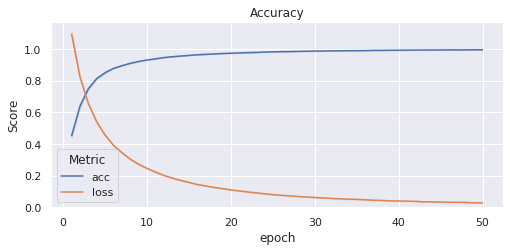

In [ ]:
dxx=pd.DataFrame()
sns.set(rc={'figure.figsize':(8.1, 3.4)})
for jx in vgg:  
  mx=50
  data=sio.loadmat(jx)
  epoch=np.arange(mx)+1

  for ix in ['acc', 'loss']:#, 'loss', 'val_loss']:
    if ix=='val_acc':
      off=0.1
    else:
      off=0.04
    fm=pd.DataFrame()
    Metric=np.array([ix for i in range(mx)])
    fm['epoch']=epoch
    
    accx=data[ix][0][:mx]

    fm['Score']=accx
    fm['Metric']=Metric

    dxx=pd.concat([dxx, fm], ignore_index=True)
plt.title('Accuracy')
sns.lineplot(x="epoch", y="Score", hue='Metric', data=dxx)
plt.ylim((0))
plt.savefig('accuracyTraining.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||##

In [ ]:
df[["result_mat", "Accuracy", 'F1_score', 'Sensitivity', 'Specificity', 'Precision', 'mean_metrics']].sort_values(by=['mean_metrics'], ascending=False)

,result_mat,Accuracy,F1_score,Sensitivity,Specificity,Precision,mean_metrics
35,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.994025,0.991435,0.987207,0.997701,0.995699,0.993213
20,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.994025,0.991453,0.989339,0.996552,0.993576,0.992989
32,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.994025,0.991471,0.991471,0.995402,0.991471,0.992768
15,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.991785,0.989573,0.981203,0.998761,0.998088,0.991882
87,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.992532,0.989712,0.983640,0.997647,0.995859,0.991878
...,...,...,...,...,...,...,...
1,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.984317,0.970043,0.982659,0.984894,0.957746,0.975932
19,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.983570,0.969101,0.971831,0.987805,0.966387,0.975739
22,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.983570,0.969188,0.974648,0.986789,0.963788,0.975596
28,Thermo_x_imagenet__ResNet50V2_adadelta_categor...,0.982076,0.966387,0.971831,0.985772,0.961003,0.973414


In [ ]:
transf=df[["result_mat", "Accuracy", 'F1_score', 'Sensitivity', 'Specificity', 'Precision', 'mean_metrics']].sort_values(by=['mean_metrics'], ascending=False).iloc[0,:][0]

In [ ]:
wig=path+'/Weights/'+transf.replace('_r.mat','w.h5')

In [ ]:
def transfer_model(path_model, confirmation_of_weights=True):
  model=get_model('ResNet50V2',weights=None)
  model.load_weights(path_model)
  y_hat=model.predict(images)
  hat=np.argmax(y_hat, axis=1)
  print('Accuracy\t:',np.mean(labels==hat))
  new_model=get_model('ResNet50V2',input_shape=(199,88,3), classes=2, weights=None)
  new_model.layers[0].set_weights(model.layers[0].get_weights())

  if confirmation_of_weights:
    w1=new_model.layers[0]
    w2=model.layers[0]
    ind=np.random.choice(269)
    print(w1.weights[ind]==w2.weights[ind])
  return new_model

In [ ]:
mx=transfer_model(wig)

done
Accuracy	: 0.9952203136669157
done
tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True


In [ ]:
trainx=np.zeros((30,199,88,3))
ytraix=one_hot(np.arange(30)%2)
mx.fit(trainx, ytraix)

1/1 [==============================] - 5s 5s/step - loss: 0.7091 - acc: 0.5000 - recall_24: 0.5000 - false_positives_25: 15.0000
